In [1]:
import numpy as np
from scipy import integrate, optimize
import matplotlib.pyplot as plt

In [2]:
class F:


    def __init__(self, omegaS, gamma, p_guess, theta_l, dtheta):
        self.omegaS = omegaS
        self.gamma = gamma
        self.p_guess = p_guess
        self.theta_l = theta_l
        self.dtheta = dtheta


    def get_omega_2(self, theta):
        fb = np.sin(theta / 2)**2
        sb = np.sin(theta)
        omega_2 = 2*self.omegaS + self.gamma*fb*sb/4

        return omega_2
    

    def __call__(self, theta, p):
        pf = self.gamma / self.get_omega_2(theta)
        fb = 9 * np.sin(theta / 2)**4 / 8
        sb = -3 * np.sin(theta)**2 / 32

        a = 10**-10
        if np.isclose(theta, np.pi, atol=a/2):
            tb = - (self.dtheta/a) * np.sum(np.sin(self.theta_l)**4 * self.p_guess)
        else:
            tb = 0

        return pf * (fb + sb) * p + pf * tb

In [3]:
def normalise(p, dtheta):
    # This is not good enough when the p diverges.
    N = dtheta * np.sum(p)

    return N

In [4]:
def get_gutzwiller_p_infty(lmbd):    
    omegaS = 1
    gamma = 4 * omegaS * lmbd
    dtheta = .01
    theta_l = np.arange(-np.pi, np.pi + dtheta, dtheta)
    # p_guess = stages.p_infty(lmbd, theta_l)
    p_guess = np.empty_like(theta_l)
    f = F(omegaS, gamma, np.ones_like(theta_l) / 2 / np.pi, theta_l, dtheta)
    omega_2 = f.get_omega_2

    minimum = optimize.minimize_scalar(omega_2, bounds=(-np.pi, np.pi))
    # zero_minus = optimize.root_scalar(omega_2, bracket=[-np.pi, minimum.x])
    if lmbd > 3.1:
        zero_plus = optimize.root_scalar(omega_2, bracket=[minimum.x, np.pi])

        b = 10**-6
        t_span_right = (0, np.pi+dtheta)
        t_span_left = (0, zero_plus.root + b)
        t_eval_right = np.arange(0, np.pi+dtheta, dtheta)
        t_eval_left = np.arange(-dtheta, zero_plus.root, -dtheta)
        p0 = np.array([1])

        t_eval_all = np.append(np.flip(t_eval_left), t_eval_right)

        p_guess = np.empty_like(t_eval_all)
        f = F(omegaS, gamma, np.ones_like(t_eval_all) / (np.pi-zero_plus.root), t_eval_all, dtheta)
        for i, theta in enumerate(t_eval_all):
            p_guess[i] = f(theta, 1)


        N = 20
        for i in range(N):
            f = F(omegaS, gamma, p_guess, theta_l, dtheta)
            p_right = integrate.solve_ivp(f, t_span_right, p0, t_eval=t_eval_right)
            p_left = integrate.solve_ivp(f, t_span_left, p0, t_eval=t_eval_left)

            p_infty = np.append(np.flip(p_left.y), p_right.y)

            N = normalise(p_infty, dtheta)# This might be wrong by a small amount
            p0 = p0 / N
            p_guess = p_infty / N

    else:
        theta_l = np.arange(-np.pi, np.pi + dtheta, dtheta)
        # p_guess = stages.p_infty(lmbd, theta_l)
        p_guess = np.empty_like(theta_l)
        f = F(omegaS, gamma, np.ones_like(theta_l) / 2 / np.pi, theta_l, dtheta)
        for i, theta in enumerate(theta_l):
            p_guess[i] = f(theta, 1)

        t_eval_all = theta_l

        t_span = (+(np.pi+dtheta), -(np.pi+dtheta))
        p0 = np.array([1])

        N = 20
        for i in range(N):
            f = F(omegaS, gamma, p_guess, theta_l, dtheta)
            data = integrate.solve_ivp(f, t_span, p0, t_eval=np.flip(theta_l))

            p_infty = data.y[0]

            N = normalise(p_infty, dtheta)# This might be wrong by a small amount
            p0 = p0 / N
            p_guess = p_infty / N

        p_guess = np.flip(p_guess)

    return t_eval_all, p_guess

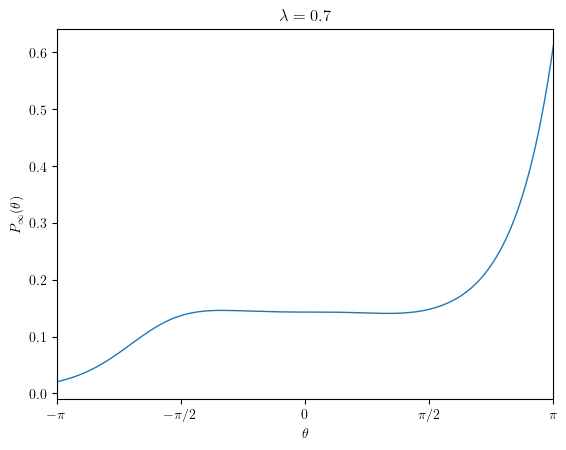

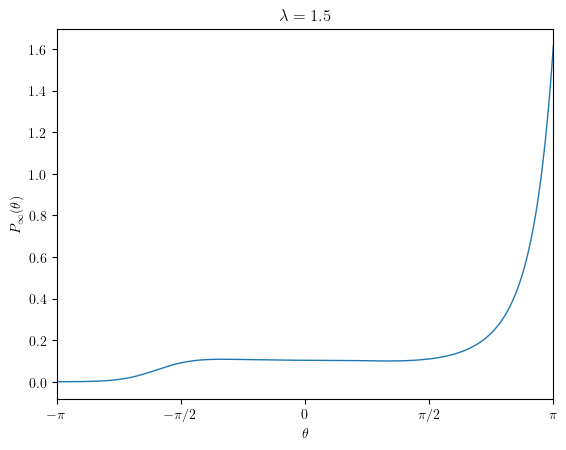

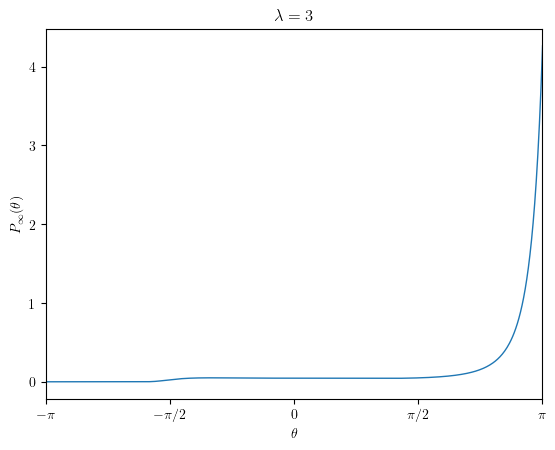

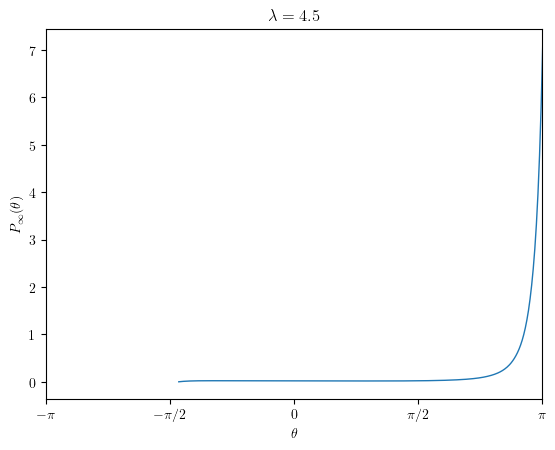

In [5]:
plt.style.use(["./config/stylelib/thesis.mplstyle"])

for lmbd in [.7, 1.5, 3, 4.5]:
    # print(lmbd)
    th, pi = get_gutzwiller_p_infty(lmbd)

    # f = open(f"data/gutzwiller-analytical-lambda={lmbd}.pkl", "wb")
    # pickle.dump([lmbd, th, pi], f)
    # f.close()

    plt.figure()
    plt.plot(th, pi)
    plt.title(rf"$\lambda = {lmbd}$")

    plt.xlim((-np.pi, np.pi))
    xticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    xlabels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
    plt.xticks(xticks, xlabels)
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$P_\infty(\theta)$")